# RQ2 Emissions Reported Analysis

This script contains the analysis for the RQ2 Emissions Reported Analysis for the 'What is the Carbon Footprint of ML Models on
Hugging Face? A Repository Mining Study' paper. The analysis can be replicated by executing the cells in order, please make sure the datasets referenced in read_df_processed and read_df_clean functions are in the corresponding directory.

In [5]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy import stats
import matplotlib

pd.options.mode.chained_assignment = None

In [6]:
width_in = 252/72.27

def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    
    return (fig_width_in, fig_height_in)


In [7]:
def read_df_processed():
    df = pd.read_csv('../../datasets/HFTotalProcessed.csv')
    df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    df['datasets'] = df['datasets'].apply(lambda datasets: [''] if pd.isnull(datasets) else [datasets] if '[' not in datasets else ast.literal_eval(datasets))

    return df

df = read_df_processed()

def read_df_co2():
    df = pd.read_csv('../../datasets/HFCO2.csv')
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    df['datasets'] = df['datasets'].apply(lambda datasets: [''] if pd.isnull(datasets) else [datasets] if '[' not in datasets else ast.literal_eval(datasets))
    df['performance_metrics'] = df['performance_metrics'].apply(lambda metrics_dict:  ast.literal_eval(metrics_dict.replace('nan', 'None')) if isinstance(metrics_dict, str) else metrics_dict)

    return df

df_co2 = read_df_co2()


def read_df_clean():
    df = pd.read_csv('../../datasets/HFClean.csv')
    df = df.drop(['Unnamed: 0'], axis=1)
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    df['datasets'] = df['datasets'].apply(lambda datasets: [''] if pd.isnull(datasets) else [datasets] if '[' not in datasets else ast.literal_eval(datasets))

    return df

df_clean = read_df_clean()

# Set to true if you want latex-style in the plots
latex = False
if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

/tmp/ipykernel_25753/3364451555.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


## Performance metrics analysis

### All models

In [8]:
df = read_df_processed()

/tmp/ipykernel_25753/3364451555.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


In [9]:
df_energy_reported = df[df['co2_reported'] == True]
df_energy_auto = df_co2[df_co2['auto'] == 'True']

In [10]:
df_energy_auto['performance_metrics'].iloc[0]

{'accuracy': None, 'f1': None, 'rouge1': 0.525404, 'rougeL': 0.501696}

In [11]:
constant = 1e-6
df_energy_auto['log_co2_eq_emissions'] = np.log(df_energy_auto['co2_eq_emissions'] + constant)

# Calculate correlation and p-value for each performance metric
performance_metrics = ['accuracy', 'f1', 'rouge1', 'rougeL']
for metric in performance_metrics:
    # Filter rows with non-missing performance metric
    metric_values = df_energy_auto['performance_metrics'].apply(lambda x: x[metric])
    df_filtered = df_energy_auto[~metric_values.isnull()]
    
    # Also filter metric_values to align with df_filtered
    filtered_metric_values = metric_values[~metric_values.isnull()]

    if not df_filtered.empty:
        correlation, p_value = stats.spearmanr(df_filtered['co2_eq_emissions'], filtered_metric_values)
        print(f"Correlation between CO2eq emissions and {metric}: {correlation}")
        print(f"P-value for {metric}: {p_value}")
    else:
        print(f"No data available for {metric}")
    print()


Correlation between CO2eq emissions and accuracy: 0.0032244550384418293
P-value for accuracy: 0.9259196067684714

Correlation between CO2eq emissions and f1: -0.014355126071879163
P-value for f1: 0.6916077268076143

Correlation between CO2eq emissions and rouge1: -0.01953244490294246
P-value for rouge1: 0.7712600666419309

Correlation between CO2eq emissions and rougeL: -0.05210677816280857
P-value for rougeL: 0.4377329988626998



### Cleaned models

In [12]:

# Log transformation of CO2eq emissions with a constant
constant = 1e-6
df_clean['log_co2_eq_emissions'] = np.log(df_clean['co2_eq_emissions'] + constant)

# Calculate correlation and p-value for each performance metric
performance_metrics = ['accuracy', 'f1', 'rouge1', 'rougeL']
for metric in performance_metrics:
    # Filter rows with non-missing performance metric
    df_filtered = df_clean[df_clean[metric].notnull()]

    if not df_filtered.empty:
        correlation, p_value = stats.spearmanr(df_filtered['co2_eq_emissions'], df_filtered[metric])
        print(f"Correlation between CO2eq emissions and {metric}: {correlation}")
        print(f"P-value for {metric}: {p_value}")
    else:
        print(f"No data available for {metric}")
    print()

Correlation between CO2eq emissions and accuracy: 0.27272727272727276
P-value for accuracy: 0.41714143714253127

Correlation between CO2eq emissions and f1: -0.3765723339400754
P-value for f1: 0.3178226816985236

Correlation between CO2eq emissions and rouge1: 0.3214285714285715
P-value for rouge1: 0.4820720382996776

Correlation between CO2eq emissions and rougeL: 0.0
P-value for rougeL: 1.0



## Pretraining vs finetuning

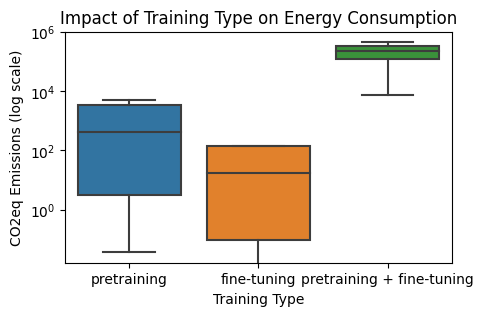

Mann-Whitney U test: statistic=333.0, p-value=0.02920509534997118


In [13]:
# Filter the DataFrame for models that reported energy consumption and training type
df_filtered = df_clean.dropna(subset=['co2_eq_emissions', 'training_type'])

# Box plot of energy consumption by training type
plt.figure(figsize=(5, 3))
sns.boxplot(data=df_filtered, x='training_type', y='co2_eq_emissions', showfliers=False)
plt.yscale('log')
plt.title('Impact of Training Type on Energy Consumption')
plt.xlabel('Training Type')
plt.ylabel('CO2eq Emissions (log scale)')
plt.show()

# Mann-Whitney U test to compare energy consumption between training types
pretraining = df_filtered[df_filtered['training_type'] == 'pretraining']['co2_eq_emissions']
fine_tuning = df_filtered[df_filtered['training_type'] == 'fine-tuning']['co2_eq_emissions']

stat, p = mannwhitneyu(pretraining, fine_tuning)
print(f'Mann-Whitney U test: statistic={stat}, p-value={p}')


In [14]:
print('pretraining mean: ', df_filtered[df_filtered['training_type'] == 'pretraining']['co2_eq_emissions'].mean())
print('finetuning mean: ',df_filtered[df_filtered['training_type'] == 'fine-tuning']['co2_eq_emissions'].mean())
print('pretraining median: ', df_filtered[df_filtered['training_type'] == 'pretraining']['co2_eq_emissions'].median())
print('finetuning median: ',df_filtered[df_filtered['training_type'] == 'fine-tuning']['co2_eq_emissions'].median())

pretraining mean:  1243469.3790219603
finetuning mean:  336.2286869880833
pretraining median:  432.6742168
finetuning median:  17.0


In [15]:
print('pretraining median: ', df_filtered[df_filtered['training_type'] == 'pretraining']['co2_eq_emissions'].median())
print('finetuning median: ',df_filtered[df_filtered['training_type'] == 'fine-tuning']['co2_eq_emissions'].median())
print('pretraining + finetuning median: ',df_filtered[df_filtered['training_type'] == 'pretraining + fine-tuning']['co2_eq_emissions'].median())

pretraining median:  432.6742168
finetuning median:  17.0
pretraining + finetuning median:  228920.0


## Model Size & Dataset Size vs CO2e

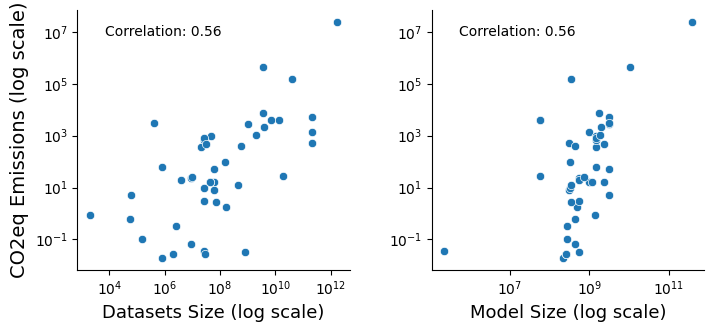

In [16]:
# Filter the DataFrame for models that reported energy consumption and size
df_filtered = df_clean.dropna(subset=['co2_eq_emissions', 'datasets_size', 'size'])

constant = 1e-6

# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(set_size(512)[0]+1, set_size(512)[1]-1))

# Scatter plot of energy consumption by datasets size
sns.scatterplot(ax=axes[0], data=df_filtered, x='datasets_size', y='co2_eq_emissions')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
# axes[0].set_title('Carbon emissions by datasets size')
axes[0].set_xlabel('Datasets Size (log scale)',fontsize=13)
axes[0].set_ylabel('CO2eq Emissions (log scale)', fontsize=14)

# Calculate and display the correlation coefficient and p-value for datasets size and CO2eq emissions
corr_coef1, p_value1 = pearsonr(np.log(df_filtered['datasets_size']+constant), np.log(df_filtered['co2_eq_emissions']+constant))
axes[0].text(0.1, 0.9, f'Correlation: {corr_coef1:.2f}', transform=axes[0].transAxes)

# Scatter plot of energy consumption by model size
sns.scatterplot(ax=axes[1], data=df_filtered, x='size', y='co2_eq_emissions')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
# axes[1].set_title('Carbon emissions by model size')
axes[1].set_xlabel('Model Size (log scale)',fontsize=13)
axes[1].set_ylabel(None)
# axes[1].set_ylabel('CO2eq Emissions (log scale)', fontsize=14)

# Calculate and display the correlation coefficient and p-value for model size and CO2eq emissions
corr_coef2, p_value2 = pearsonr(np.log(df_filtered['size']+constant), np.log(df_filtered['co2_eq_emissions']+constant))
axes[1].text(0.1, 0.9, f'Correlation: {corr_coef2:.2f}', transform=axes[1].transAxes)

# Adjust the margin between the figures
plt.subplots_adjust(wspace=0.3)
sns.despine()
# plt.savefig('model_dataset_size_carbonemissions.pdf', bbox_inches='tight')
plt.show()


Checking normality for correctness of correlation

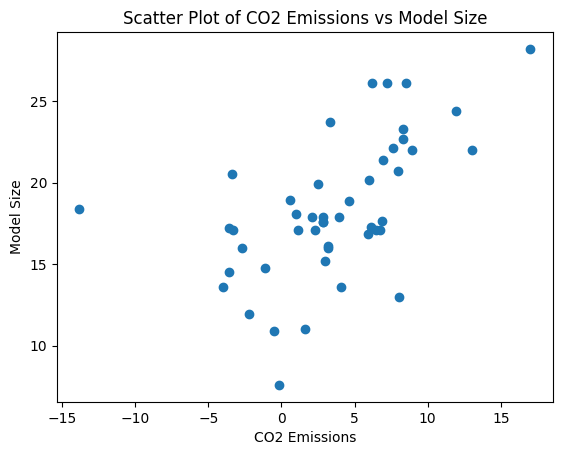

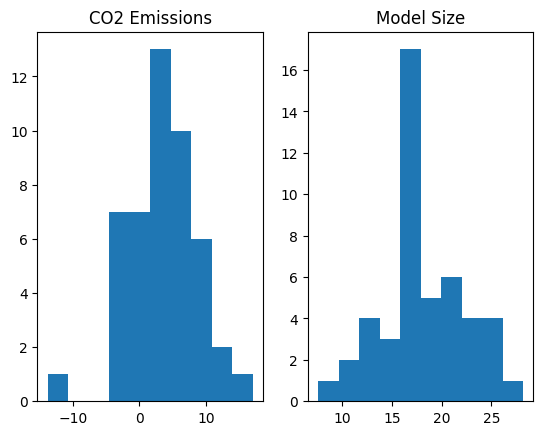

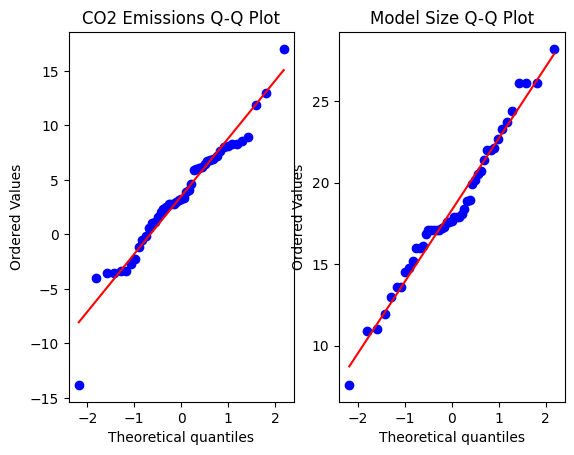

Pearson correlation: 0.5604251133350532 p-value: 4.190761324292362e-05
Spearman correlation: 0.5910603767900025 p-value: 1.2182854813542609e-05


In [17]:
# Sample data
constant = 1e-6
df_filtered = df_clean.dropna(subset=['co2_eq_emissions', 'datasets_size', 'size'])

co2_eq_emissions = np.log(df_filtered['co2_eq_emissions']+constant)
model_size = np.log(df_filtered['datasets_size']+constant)

# co2_eq_emissions = df_filtered['co2_eq_emissions']
# model_size = df_filtered['size']

# Step 1: Visualize the relationship between the two variables using a scatter plot
plt.scatter(co2_eq_emissions, model_size)
plt.xlabel('CO2 Emissions')
plt.ylabel('Model Size')
plt.title('Scatter Plot of CO2 Emissions vs Model Size')
plt.show()

# Step 2: Check the distribution of each variable using histograms and Q-Q plots
# Histograms
plt.subplot(1, 2, 1)
plt.hist(co2_eq_emissions)
plt.title('CO2 Emissions')

plt.subplot(1, 2, 2)
plt.hist(model_size)
plt.title('Model Size')

plt.show()

# Q-Q plots
plt.subplot(1, 2, 1)
stats.probplot(co2_eq_emissions, dist='norm', plot=plt)
plt.title('CO2 Emissions Q-Q Plot')

plt.subplot(1, 2, 2)
stats.probplot(model_size, dist='norm', plot=plt)
plt.title('Model Size Q-Q Plot')

plt.show()

# Step 3: Calculate Pearson and Spearman correlations
pearson_corr, pearson_pvalue = stats.pearsonr(co2_eq_emissions, model_size)
spearman_corr, spearman_pvalue = stats.spearmanr(co2_eq_emissions, model_size)

print("Pearson correlation:", pearson_corr, "p-value:", pearson_pvalue)
print("Spearman correlation:", spearman_corr, "p-value:", spearman_pvalue)


In [18]:
# Log transformation with a constant
constant = 1e-6

log_co2_eq_emissions = np.log(df_clean['co2_eq_emissions'] + constant)
log_size = np.log(df_clean['size'] + constant)

# Pearson correlation test
correlation, p_value = stats.pearsonr(log_co2_eq_emissions, log_size)

print(f"Correlation log(co2e) - log(model size): {correlation}")
print(f"P-value log(co2e) - log(model size): {p_value}")

# Drop rows containing NaN or infinite values
df_clean_nan = df_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=['co2_eq_emissions', 'datasets_size'])

# Pearson correlation test
correlation, p_value = stats.pearsonr( np.log(df_clean_nan['co2_eq_emissions'] + constant) ,  np.log(df_clean_nan['datasets_size'] + constant))

print(f"Correlation log(co2e) - log(data size): {correlation}")
print(f"P-value log(co2e) - log(data size): {p_value}")

log_co2_eq_emissions = np.log(df_filtered['co2_eq_emissions'] + constant)
log_size = np.log(df_filtered['datasets_size'] + constant)

# Pearson correlation test



Correlation log(co2e) - log(model size): 0.5614984878926341
P-value log(co2e) - log(model size): 3.294350083195913e-05
Correlation log(co2e) - log(data size): 0.5604251133350532
P-value log(co2e) - log(data size): 4.190761324292362e-05


## Domain Analysis

            domain          mean    median            std  count
0  Computer Vision      7.480591  1.171724      26.794104    188
1              NLP  21770.941347  4.988945  725242.617942   1160


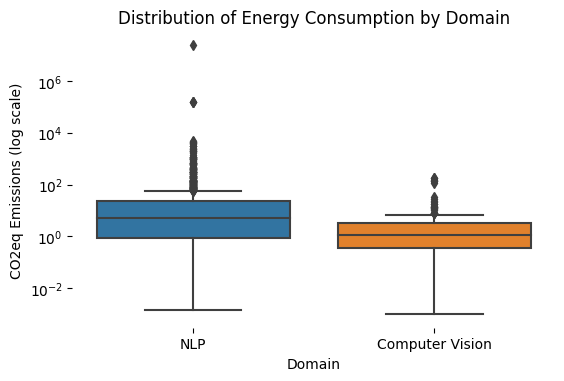

In [19]:
if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })


# 1. Filter models that reported energy consumption
df_energy_reported = df[df['co2_reported'] == True]

# 1.1 Filter models with 'NLP' and 'Computer Vision' domains
df_filtered_domains = df_energy_reported[df_energy_reported['domain'].isin(['NLP', 'Computer Vision'])]

# 2. Group models by domain and compute basic statistics
domain_stats = df_filtered_domains.groupby('domain')['co2_eq_emissions'].agg(['mean', 'median', 'std', 'count']).reset_index()
print(domain_stats)



# 3. Investigate the distribution of energy consumption in each domain
plt.figure(figsize=set_size(450))
sns.boxplot(x='domain', y='co2_eq_emissions', data=df_filtered_domains)
plt.yscale('log')
plt.title('Distribution of Energy Consumption by Domain')
plt.xlabel('Domain')
plt.ylabel('CO2eq Emissions (log scale)')

sns.despine(left=True, bottom=True) 

# plt.savefig('domain_carbon_emissions.pdf', bbox_inches='tight')
plt.show()


In [20]:
cv_energy = df_energy_reported[df_energy_reported['domain'] == 'Computer Vision']['co2_eq_emissions']
nlp_energy = df_energy_reported[df_energy_reported['domain'] == 'NLP']['co2_eq_emissions']
u_stat, p_value = mannwhitneyu(cv_energy, nlp_energy, alternative='two-sided')

Remember, these p-values still should be corrected!! Correction on HFGeneralAnalysis.ipynb

In [21]:
print(f"Mann-Whitney U test result: U_stat = {u_stat:.5f}, p-value = {p_value:.5f}")

Mann-Whitney U test result: U_stat = 69376.00000, p-value = 0.00000


In [31]:
df_energy_reported['co2_eq_emissions_model_size_normalized'] = df_energy_reported['co2_eq_emissions'] / df_energy_reported['size']

In [40]:
cv_energy = df_energy_reported[df_energy_reported['domain'] == 'Computer Vision']['size']
nlp_energy = df_energy_reported[df_energy_reported['domain'] == 'NLP']['size']
cv_energy = [energy for energy in cv_energy if not pd.isnull(energy)]
nlp_energy = [energy for energy in nlp_energy if not pd.isnull(energy)]
u_stat, p_value = mannwhitneyu(cv_energy, nlp_energy, alternative='two-sided')

p_value

2.8670557650479784e-51

In [35]:
cv_energy = df_energy_reported[df_energy_reported['domain'] == 'Computer Vision']['co2_eq_emissions_model_size_normalized']
nlp_energy = df_energy_reported[df_energy_reported['domain'] == 'NLP']['co2_eq_emissions_model_size_normalized']
cv_energy = [energy for energy in cv_energy if not pd.isnull(energy)]
nlp_energy = [energy for energy in nlp_energy if not pd.isnull(energy)]
u_stat, p_value = mannwhitneyu(cv_energy, nlp_energy, alternative='two-sided')

In [37]:
print(f"Mann-Whitney U test result: U_stat = {u_stat:.5f}, p-value = {p_value:.5f}")

Mann-Whitney U test result: U_stat = 87169.00000, p-value = 0.00464


### Linear regression to check NLP real influence

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [105]:
# Create binary variables for domain

df_filtered = df_energy_reported.dropna(subset=['size', 'co2_eq_emissions'])

df_filtered['is_nlp'] = df_filtered['domain'].apply(lambda x: 1 if x == 'NLP' else 0)
df_filtered['is_cv'] = df_filtered['domain'].apply(lambda x: 1 if x == 'Computer Vision' else 0)

# Normalize model size and dataset size (optional but recommended)
df_filtered['normalized_model_size'] = np.log(df_filtered['size']+constant)
# df_filtered['normalized_dataset_size'] = np.log1p(df_filtered['datasets_size']+constant)

predictors = df_filtered[['is_nlp', 'is_cv', 'normalized_model_size']]
target = np.log(df_filtered['co2_eq_emissions']+constant)

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The coefficients
print("Coefficients: ", reg.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))



Coefficients:  [-1.87226239 -2.63440391  0.77057011]
Mean squared error: 8.44
Coefficient of determination: 0.06


In [106]:
# Add a constant term to the predictors
X_train_with_constant = sm.add_constant(X_train)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train_with_constant).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       co2_eq_emissions   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     30.89
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           4.00e-19
Time:                        05:58:32   Log-Likelihood:                -2572.3
No. Observations:                1038   AIC:                             5153.
Df Residuals:                    1034   BIC:                             5172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.61

In [107]:
stats.spearmanr(df_filtered['is_nlp'], df_filtered['size'])

SignificanceResult(statistic=0.41456193953927845, pvalue=4.540045992805753e-55)

# Combination

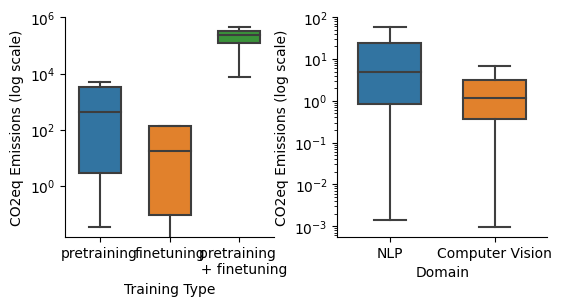

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Filter the DataFrame for models that reported energy consumption and training type
df_filtered = df_clean.dropna(subset=['co2_eq_emissions', 'training_type'])

# Filter models with 'NLP' and 'Computer Vision' domains
df_filtered_domains = df_energy_reported[df_energy_reported['domain'].isin(['NLP', 'Computer Vision'])]

# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(set_size(450)[0], set_size(450)[1]-1))


# Box plot of energy consumption by training type
sns.boxplot(ax=axes[0], data=df_filtered, x='training_type', y='co2_eq_emissions', showfliers=False, width=0.6, dodge=True)
axes[0].set_yscale('log')
# axes[0].set_title('Carbon Emissions by Training Type')
axes[0].set_xlabel('Training Type')
axes[0].set_ylabel('CO2eq Emissions (log scale)')
training_type_labels = ['pretraining', 'finetuning', 'pretraining \n  + finetuning']
axes[0].set_xticklabels(training_type_labels)

# Box plot of energy consumption by domain
sns.boxplot(ax=axes[1], data=df_filtered_domains, x='domain', y='co2_eq_emissions', showfliers=False, width=0.6)
axes[1].set_yscale('log')
# axes[1].set_title(' Carbon Emission by Domain')
axes[1].set_xlabel('Domain')
axes[1].set_ylabel('CO2eq Emissions (log scale)')



# Remove black lines around the figure axes
sns.despine(left=False)
plt.subplots_adjust(wspace=0.3)

# plt.savefig('domain_trainingtype_carbon_emissions.pdf', bbox_inches='tight')

plt.show()


# Energy efficency classification

In [109]:
def read_df_co2_processed():
    """Reads processed dataset from CSV and applies necessary transformations."""
    df = pd.read_csv('../../datasets/HFCO2.csv')
    
    # Convert string representation of library list to actual list
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    
    return df


In [110]:
df = read_df_co2_processed()
df['datasets_size_efficency'] = df['datasets_size'] / df['co2_eq_emissions']


In [129]:
import pandas as pd
import numpy as np
import streamlit as st
import ast

# Weightage of different metrics for energy efficiency computation
METRIC_WEIGHTS = {
    'co2_eq_emissions': 0.35,
    'size_efficency': 0.15,
    'datasets_size_efficency': 0.15,
    'downloads': 0.25,
    'performance_score': 0.2
}

# Metrics where a higher value is better
HIGHER_BETTER = [
    'performance_score',
    'size_efficency',
    'datasets_size_efficency',
    'downloads'
]

# Metrics to be scaled by a power transformation
POWER_SCALE_METRICS = [
    'downloads',
    'co2_eq_emissions'
]



# Turn off pandas warning for chained assignment
pd.options.mode.chained_assignment = None

def weighted_mean(ratings, weights):
    """
    Compute weighted mean of ratings.

    Args:
    ratings : list of ratings
    weights : corresponding weights for the ratings

    Returns:
    weighted mean : weighted mean of ratings
    """
    # Remove NaN values and their corresponding weights
    not_nan_indices = np.isfinite(ratings)
    ratings_clean = np.array(ratings)[not_nan_indices]
    weights_clean = np.array(weights)[not_nan_indices]
    
    # Renormalize the weights
    weights_clean = weights_clean / np.sum(weights_clean)

    # Compute the weighted mean
    mean = np.sum(ratings_clean * weights_clean)
    
    return int(round(mean))

def assign_rating(index, boundaries):
    """
    Assigns a rating based on index value. If index is within certain boundaries, 
    a specific rating is given.

    Args:
    index : index value for which rating is to be assigned
    boundaries : list of boundaries for rating

    Returns:
    rating : assigned rating
    """
    if index is None or pd.isnull(index):
        return np.nan

    for i, (upper, lower) in enumerate(boundaries):
        if index <= upper and index > lower:
            return i
    return 4 # worst rating if index does not fall in boundaries

def calculate_compound_rating(ratings, weights=None, meanings='ABCDE', mode='mean'):
    """
    Calculates a compound rating based on individual ratings and their weights.

    Args:
    ratings : list of individual ratings
    weights : list of weights corresponding to the ratings
    meanings : string representing different ratings, default is 'ABCDE'
    mode : method to calculate compound rating, default is 'mean'

    Returns:
    compound rating
    """
    if all(x is None or pd.isna(x) for x in ratings):
        return None
    if weights is None:
        weights = [1.0 / len(ratings) for _ in ratings]
    if mode == 'mean':
        return meanings[weighted_mean(ratings, weights)]

def value_to_index(value, ref, metric):
    """
    Convert a value to an index by normalizing it with a reference value.
    If the metric is higher better, index is value divided by reference value,
    otherwise index is reference value divided by value.

    Args:
    value : value to be converted
    ref : reference value for normalization
    metric : name of the metric

    Returns:
    index
    """
    if pd.isnull(value) or value is None:
        return None

    try:
        return value / ref if metric in HIGHER_BETTER else ref / value
    except:
        return 0


def compute_boundaries(df, metric, metrics_ref, index=True):
    """
    Compute the boundaries for assigning ratings based on the distribution of metric values.
    Args:
    df : DataFrame containing the metrics
    metric : the metric for which to compute the boundaries
    metrics_ref : reference metrics for normalization
    index : if True, convert metric values to indices before computing boundaries
    Returns:
    boundaries for ratings
    """
    if index:
        metric_parameters = df[metric].apply(lambda x: value_to_index(x, metrics_ref[metric], metric))
    else:
        metric_parameters = df[metric]

    if metric == 'co2_eq_emissions':
        return np.nanpercentile(np.sqrt(metric_parameters), [20, 40, 60, 80])[::-1]
    if metric == 'downloads':
        return np.nanpercentile(metric_parameters, [60,85,94,96])[::-1]
    else:
        return np.nanpercentile(metric_parameters, [20, 40, 60, 80])[::-1]



def load_ref_metrics(df, model_name='distilgpt2'):
    """
    Load reference metrics for a specified model from the dataset. If the value is missing,
    the median value for the metric in the dataset is used.
    Args:
    df : DataFrame containing the metrics
    model_name : name of the model to use as reference
    Returns:
    dictionary of reference metrics
    """
    metrics = list(METRIC_WEIGHTS.keys())
    ref_model = df[df['modelId'] == model_name].iloc[0]

    metrics_ref = {metric: ref_model[metric] if not pd.isnull(ref_model[metric]) else df[metric].median() for metric in metrics}

    return metrics_ref


def load_boundaries(df, metrics, metrics_ref, index=True):
    """
    Compute boundaries for all metrics and convert them to intervals.
    Args:
    df : DataFrame containing the metrics
    metrics : list of metrics for which to compute boundaries
    metrics_ref : reference metrics for normalization
    index : if True, convert metric values to indices before computing boundaries
    Returns:
    dictionary of boundary intervals for each metric
    """
    boundaries = {metric:compute_boundaries(df, metric, metrics_ref) for metric in metrics}

    max_value = float('inf')
    min_value = 0

    boundary_intervals = {}

    for key, boundaries in boundaries.items():
        intervals = [[max_value, boundaries[0]]]
        for i in range(len(boundaries)-1):
            intervals.append([boundaries[i], boundaries[i+1]])
        intervals.append([boundaries[-1], min_value])
        
        boundary_intervals[key] = intervals

    return boundary_intervals

def assign_energy_label(metrics, metrics_ref, boundaries, meanings, rating_mode, index=True):
    """
    Assigns an energy efficiency label based on the metrics.

    Args:
    metrics : dictionary of metrics
    metrics_ref : reference metrics for normalization
    boundaries : boundary intervals for each metric
    meanings : string representing different ratings
    rating_mode : method to calculate compound rating
    index : if True, convert metric values to indices before assigning label

    Returns:
    compound rating and dictionary of individual ratings
    """
    weights = list(METRIC_WEIGHTS.values())
    if index:
        metrics = {metric: value_to_index(value, metrics_ref[metric], metric) for metric, value in metrics.items()}

    metrics_to_rating = (
        {metric:
          assign_rating(value, boundaries[metric])
          for metric, value in metrics.items()})
    
    ratings = list(metrics_to_rating.values())
    return calculate_compound_rating(ratings, weights, meanings, rating_mode), metrics_to_rating




def add_index_metrics(df):
    """
    Add index metrics to dataframe.

    Args:
    df : dataframe

    Returns:
    dataframe with index metrics
    """
    metrics = list(METRIC_WEIGHTS.keys())
    metrics_ref = load_ref_metrics(df)
    for metric in metrics:
        df[metric + '_index'] = df[metric].apply(lambda value: value_to_index(value, metrics_ref[metric], metric))
    return df
    

def wrapper_assign_energy_label(row, metrics_ref, boundaries, meanings, rating_mode, index=True):
    """
    Wrapper function for assign_energy_label to be used with pandas apply.
    """

    val1, val2 = assign_energy_label(row, metrics_ref, boundaries, 'ABCDE', 'mean') 
    return pd.Series([val1, val2])
    

def assign_energy_label_to_df(df, index=True):
    """
    Assigns energy efficiency labels to dataframe.

    Args:
    df : dataframe
    index : if True, convert metric values to indices before assigning label

    Returns:
    dataframe with energy efficiency labels
    """
                       
    metrics = list(METRIC_WEIGHTS.keys())
    metrics_ref = load_ref_metrics(df)
    
    boundaries = load_boundaries(df, metrics, metrics_ref)


    df[['compound_rating', 'metrics_to_rating']] = df[metrics].apply(lambda row: wrapper_assign_energy_label(row, metrics_ref, boundaries, 'ABCDE', 'mean') , axis=1)
    

    return df

df_co2 = df[df['co2_reported'] == True]

df_co2 = assign_energy_label_to_df(df_co2)

/tmp/ipykernel_36061/1812421127.py:116: RuntimeWarning: divide by zero encountered in scalar divide
  return value / ref if metric in HIGHER_BETTER else ref / value


In [130]:
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())


def performance_score(df):
    metrics = ['accuracy', 'f1', 'rouge1', 'rougeL']
    
    df['f1'] = min_max_normalize(df['f1'])
    df['accuracy'] = min_max_normalize(df['accuracy'])
    df['rouge1'] = min_max_normalize(df['rouge1'])
    df['rougeL'] = min_max_normalize(df['rougeL'])
    
    return df.apply(lambda row: stats.hmean([row[metric] for metric in metrics if not np.isnan(row[metric])]), axis=1)

In [131]:
df_co2['compound_rating'].value_counts()

compound_rating
C    813
B    491
D     68
A     32
E     15
Name: count, dtype: int64

Below you can select the energy label you prefer to investigate the top models by downloads on that energy label

In [137]:
df_co2[df_co2['compound_rating'] == 'B'].sort_values(by='likes', ascending=False)[['modelId','downloads', 'co2_eq_emissions', 'size_efficency','performance_score', 'performance_metrics']]

,modelId,downloads,co2_eq_emissions,size_efficency,performance_score,performance_metrics
626,AI-image-detector,1505,7.940487,4.377521e+07,0.949933,"{'accuracy': 0.942, 'f1': 0.958, 'rouge1': nan..."
454,auditor_sentiment_finetuned,76,3.165772,1.386984e+08,0.846878,"{'accuracy': 0.848937, 'f1': 0.844828435291268..."
1338,autotrain-meme-classification-42897109437,32,1.132924,3.068164e+08,1.000000,"{'accuracy': 1.0, 'f1': 1.0, 'rouge1': nan, 'r..."
46,headline_writer,148,114.712928,4.864135e+06,0.496934,"{'accuracy': nan, 'f1': nan, 'rouge1': 0.52498..."
629,autotrain-in-class-test-demo-1659958767,4,0.150317,NaN,0.979487,"{'accuracy': 0.983, 'f1': 0.976, 'rouge1': nan..."
...,...,...,...,...,...,...
533,autotrain-app_review_train_roberta-1314150168,12,0.015900,3.136135e+10,0.823830,"{'accuracy': 0.801, 'f1': 0.848, 'rouge1': nan..."
530,autotrain-bert-NER-favsbot,7,0.012035,1.110560e+11,0.564143,"{'accuracy': 0.71, 'f1': 0.468, 'rouge1': nan,..."
526,autotrain-neurips_chanllenge-1287149278,15,0.039558,3.373427e+10,0.723677,"{'accuracy': 0.907, 'f1': 0.602, 'rouge1': nan..."
524,ni_model_8_19,67,7.709203,1.731035e+08,0.724602,"{'accuracy': 0.849, 'f1': 0.632, 'rouge1': nan..."
